In [1]:
# !pip install mesa

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# https://mesa.readthedocs.io/en/stable/

## To-Do:

* Optimierung: kriegen wirs besser hin. Benchmarks in Netlogo? 
* Agent.py https://agentpy.readthedocs.io/en/latest/
* Syntax für Gruppen? Gruppensyntax als Klasse? (Visualisierung als Methode)
* Visualierung: phylogenetic tree, bubblechart, treemap
* **Gruppen umsetzen** 
* UMAP embedding von Strategien, Visualisierung Bokeh, Faerun?
* Evaluierungsfunktionen, visualisierungen
* ABMs in R?




In [ ]:
# Gruppenstruktur:

[
[
[a,b],
[c,d]
],
e,
f]

In [7]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


class MyAgent(Agent):
    def __init__(self, name, model, memory=10, n_strategies=10, threshold=50):

        super().__init__(name, model)

        self.name = name
        self.memory = memory
        self.n_strategies = n_strategies
        self.threshold = threshold

        self.my_strategies = np.random.rand(n_strategies, memory + 1)

        self.should_i_attend = np.random.rand() > self.threshold  # set first attendance
        self.my_attendance = [self.should_i_attend]

    # To get teams, instantiate new actor, maybe with different properties & slower updating,
    # and set all contributing actors to in_team (which can be false or id of team) which makes them
    # update according to the team decision.

    def step(self):

        history = list(
            +self.model.datacollector.get_model_vars_dataframe()[  # innefficient
                "attendance"
            ]
        )
        self.my_attendance.append(self.should_i_attend)

        best_strategy = self.select_strategy(
            self.my_attendance, self.my_strategies, history
        )

        prediction = self.my_strategies[
            best_strategy, -1
        ]  # get the prediction (last column) from the stategy that performed best.

        self.should_i_attend = prediction < self.threshold  # strict? (<,<=,)
        self.my_attendance.append(self.should_i_attend)

    def select_strategy(self, my_attendance, strategies, history):
        memory_to_use = np.min((len(history), self.memory))
        strategy_window = strategies[:, -(memory_to_use + 1) : -1]

        #       compute error of strategies over the relevant timespan:
        #       This currently assumes perfect information Change!

        history_window = np.array(
            history[-memory_to_use:] * strategies.shape[0]
        ).reshape(strategy_window.shape)

        mean_predictions = np.mean(
            np.abs(history_window - strategy_window),
            axis=1,
        ).reshape(-1, 1)
        #         print(mean_predictions.shape)
        #       select strategy with minimal error:
        return np.argmin(mean_predictions)


class MyModel(Model):
    def __init__(self, n_agents, memory, n_strategies, threshold):
        super().__init__()
        self.schedule = RandomActivation(self)

        self.attendance = 1
        for i in range(n_agents):
            a = MyAgent(i, self, memory, n_strategies, threshold)
            self.schedule.add(a)
        #             coords = (self.random.randrange(0, 10), self.random.randrange(0, 10))
        #             self.grid.place_agent(a, coords)

        agent_reporters = {
            "should_i_attend": lambda a: getattr(a, "should_i_attend", None),
        }

        model_reporters = {
            "attendance": lambda a: getattr(a, "attendance", None),
        }

        self.datacollector = DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )

    def step(self):

        self.attendance = np.mean(
            [np.int(a.should_i_attend) for a in model.schedule.agents]
        )

        self.datacollector.collect(self)
        self.schedule.step()


model = MyModel(100, memory=30, n_strategies=30, threshold=0.5)


# Do the run:
for t in tqdm.tqdm_notebook(range(200)):
    model.step()

<IPython.core.display.Javascript object>

In [8]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

<IPython.core.display.Javascript object>

(0.0, 1.0)

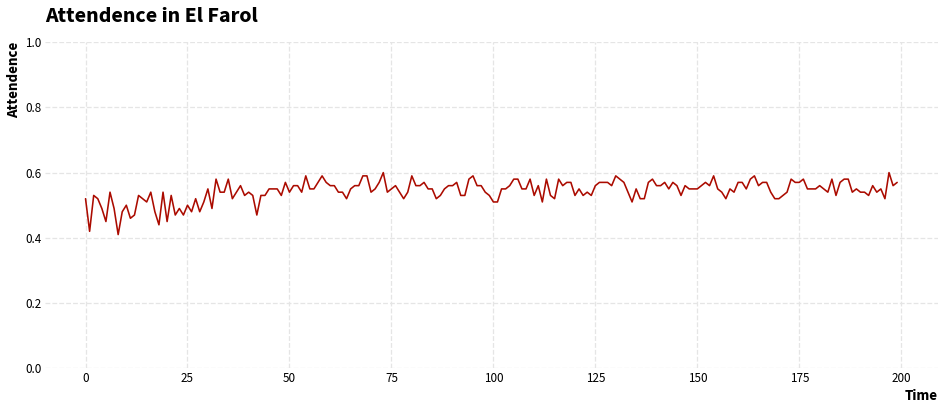

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.style.use("opinions.mplstyle")
plt.plot(model_df["attendance"], linewidth=1.6, c="#ab0b00", alpha=1)
plt.xlabel("Time")
plt.ylabel("Attendence")
plt.title("Attendence in El Farol")
plt.ylim(0,1)
# fig.suptitle("Attendence in El Farol")


In [10]:
# model_df

<IPython.core.display.Javascript object>

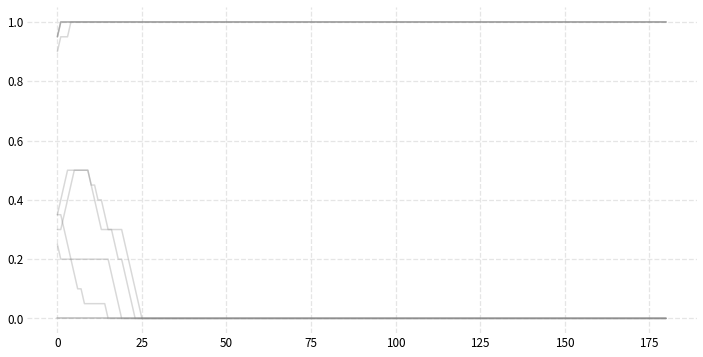

<IPython.core.display.Javascript object>

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


fig, ax = plt.subplots(figsize=(12, 6))
plt.style.use("opinions.mplstyle")
for agent_no in range(0, 10):
    agent_attendance = agent_df.iloc[
        agent_df.index.get_level_values("AgentID") == agent_no
    ]["should_i_attend"].astype(int)[0:200]

    plt.plot(moving_average(agent_attendance, 20), alpha=0.3, c="grey")